Imports the Firedrake library to initialize the simulation environment and sets Matplotlib to display plots inline:

In [1]:
import firedrake
%matplotlib inline

Imports for FEM simulation and Mass-Lumping. Includes firedrake and finat (essential for constructing custom quadrature rules for mass-lumping). Also imports numpy, math, scipy.signal, and future firedrake functionalities:

In [2]:
from firedrake import *
import finat
import math
import numpy as np
from scipy.signal import convolve
from firedrake.__future__ import interpolate
import os
from firedrake import VTKFile
from scipy.signal import convolve
import matplotlib.pyplot as plt

Creates Uniform Rectangle Mesh. Defines a 2D triangular mesh:

In [3]:
mesh = RectangleMesh(100, 100, 0.0, 0.0, 4.0, 4.0)

Function Space and Time-Stepping Variables Setup (KMV, degree 2). Defines the Function Space V (continuous KMV, degree 2). Declares the Trial (u) and Test (v) variables, and the solution state functions at time steps n+1, n, and n-1:

In [4]:
V = FunctionSpace(mesh, "KMV", 2)

u = TrialFunction(V)
v = TestFunction(V)

u_np1 = Function(V)  # timestep n+1
u_n = Function(V)    # timestep n
u_nm1 = Function(V)  # timestep n-1

Time Parameter Configuration. Defines total simulation time, the timestep size, and initializes current time and the step counter:

In [5]:
T = 1.0
dt = 0.001
t = 0
step = 0

Output Setup and VTK File Initialization. Defines and creates the output directory. Initializes the vtk object for writing results in PVD/VTK format:

In [6]:
root = "." 
outdir = os.path.join(root, "outputs", "scalar_wave_equation-out")
os.makedirs(outdir, exist_ok=True)
vtk = VTKFile(os.path.join(outdir, "scalar_wave_equation.pvd"))

Excitation and propagation parameter definition. Defines the peak frequency for the Ricker Wavelet and the constant wave velocity in the domain:

In [7]:
freq = 6

x, z = SpatialCoordinate(mesh)

V_c = FunctionSpace(mesh, "DG", 0) 

c_agua = 1.5  # Velocidade do meio 1 (água, topo)
c_rocha = 3.0 # Velocidade do meio 2 (rocha/solo, base)
z_interface = 2.0 # Posição y da interface (a malha vai de y=0 a y=4.0)

# 4. Expressão Condicional para a velocidade 'c' (HEterogênea)
# Se y > y_interface (acima), c = c_agua. Senão (abaixo), c = c_rocha.
c_expr = conditional(z > z_interface, Constant(c_agua), Constant(c_rocha))

# 5. Função Firedrake para a velocidade (Função heterogênea)
c = Function(V_c).interpolate(c_expr)

# 6. Variável para o cálculo da Solução Analítica (HOMOGÊNEA)
# Usamos a velocidade da rocha, pois posicionaremos a fonte e o receptor lá.
c_analitica = Constant(c_rocha)

Defines the function RickerWavelet which computes the seismic wave's amplitude at a given time and frequency. This function models the waveform that will be injected into the domain:

In [8]:
def RickerWavelet(t, freq, amp=1.0):
    t_shifted = t - 1.0 / freq
    factor = 1 - 2 * math.pi**2 * (freq**2) * (t_shifted**2)
    envelope = math.exp(-math.pi**2 * (freq**2) * (t_shifted**2))
    return amp * factor * envelope

Defines the delta_expr function (a Gaussian kernel) that models the spatial location of the wave source:

In [9]:
def delta_expr(x0, x, y, sigma_x=2000.0):
    sigma_x = Constant(sigma_x)
    return exp(-sigma_x * ((x - x0[0]) ** 2 + (z - x0[1]) ** 2))

Uses the finat library to create a custom "KMV" quadrature rule. This rule is essential for computing the Diagonalized Mass Matrix (Mass-Lumping), using the cell type and degree from the Function Space V:

In [10]:
quad_rule = finat.quadrature.make_quadrature(V.finat_element.cell, V.ufl_element().degree(), "KMV")

Creates a new integration measure dxlump. It forces the integral calculation (and thus matrix assembly) to use the custom KMV quadrature rule, which is essential to obtain the Diagonal Mass Matrix:

In [11]:
dxlump=dx(scheme=quad_rule)

Defines the bilinear form $\mathbf{m}$ (the left side of the mass matrix) using the central finite difference operator in time, $\mathbf{(u - 2u_n + u_{n-1}) / \Delta t^2}$. Crucially, it uses the dxlump measure to incorporate the custom KMV quadrature rule, resulting in a Diagonalized Mass Matrix.

In [12]:
m = (u - 2.0 * u_n + u_nm1) / Constant(dt * dt) * v * dxlump

Defines the bilinear form $\mathbf{a}$ (Stiffness Matrix). It represents the diffusion term $\mathbf{c^2 \nabla^2 u}$ of the wave equation, using time step $\mathbf{n}$ (explicit treatment) and the standard integration measure dx (standard quadrature):

In [13]:
a = c*c*dot(grad(u_n), grad(v)) * dx

Defines the spatial coordinates of the mesh. Locates the source point source at the domain center. Initializes the temporal source amplitude function ricker and assigns it the value of the RickerWavelet at the current time:

In [14]:
# Célula [14] Modificada: Posição da Fonte e Amplitude Temporal
x, y = SpatialCoordinate(mesh)

# Fonte posicionada na ROCHA (x=2.0 (centro), y=1.0 (abaixo da interface y=2.0))
source = Constant([2.0, 2.5]) 

ricker = Constant(0.0)
ricker.assign(RickerWavelet(t, freq))

Constant([-0.00096925], name='constant_7', count=7)

Initializes the vector R as a Cofunction in the dual space. This object is used to store the assembled Right-Hand Side (RHS) vector of the linear system, which will include the stiffness and source terms:

In [15]:
R = Cofunction(V.dual())

Defines the total variational form $\mathbf{F}$, combining the Diagonalized Mass Matrix, Stiffness Matrix, and the source term. Splits $\mathbf{F}$ into Left-Hand Side and Right-Hand Side. Assembles the Mass Matrix $\mathbf{A}$ and sets up the PETSc solver (Jacobi type with 'preonly' preconditioner) for efficient solution of the linear system:

In [16]:
F = m + a -  delta_expr(source, x, y)*ricker * v * dx
a, r = lhs(F), rhs(F)
A = assemble(a)
solver = LinearSolver(A, solver_parameters={"ksp_type": "preonly", "pc_type": "jacobi"})

/usr/local/lib/python3.12/dist-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(


Defines the function analitic_solution_2D_green. The parameter $\mathbf{P}$ is a scaling factor. The function computes the exact solution of the wave equation at time $\mathbf{t}$ (for a point pulse), which is a circular wave propagating at velocity $\mathbf{c}$. The conditional function ensures the solution is only non-zero where the wave has already reached ($\mathbf{r < c \cdot t}$):

In [17]:
# Célula [17] Modificada: Solução Analítica (usando a velocidade do meio local)
P = 0.0011
def analitic_solution_2D_green(mesh, t):
    x = SpatialCoordinate(mesh)
    r = sqrt((x[0] - source[0])**2 + (z - source[1])**2)
    # Usa a variável c_analitica definida na Célula [7]
    ct = c_analitica * t 
    phi_analytical = conditional(lt(r, ct), (c_analitica * P / (2.0 * pi)) / sqrt(ct**2 - r**2), Constant(0.0))
    return phi_analytical

Defines the receiver point coordinates ($\mathbf{receptor\_coords}$), initial amplitude ($\mathbf{amp}$), and empty lists to store the history of the numerical solution ($\mathbf{u\_numerical\_history}$) and the analytical solution ($\mathbf{G\_history}$) at the receiver, along with the time steps ($\mathbf{time\_points}$). Initializes a time_const constant to track time within the simulation loop:

In [18]:
# Célula [18] Modificada: Configuração do Receptor
# Receptor posicionado na ROCHA (y=1.2, abaixo da interface y=2.0)
receptor_coords = (2.0, 2.15) 
amp = 1.0
u_numerical_history = []
G_history = []
time_points = []
time_const = Constant(0.0)

Now we are ready to start the time-stepping loop:

In [19]:
step = 0
while t < T:
    step += 1
    ricker.assign(RickerWavelet(t, freq, amp=amp))
    R = assemble(r, tensor=R)
    solver.solve(u_np1, R)
    t += dt
    time_const.assign(t)
    u_numerical_history.append(u_np1.at(receptor_coords))
    phi_expr = analitic_solution_2D_green(mesh, time_const)
    G_history.append(assemble(interpolate(phi_expr, V)).at(receptor_coords))
    time_points.append(t)
    u_nm1.assign(u_n)
    u_n.assign(u_np1)
    if step % 10 == 0:
        print("Elapsed time is: "+str(t))
        vtk.write(u_n, time=t)

/usr/local/lib/python3.12/dist-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(


Elapsed time is: 0.010000000000000002
Elapsed time is: 0.02000000000000001
Elapsed time is: 0.03000000000000002
Elapsed time is: 0.04000000000000003
Elapsed time is: 0.05000000000000004
Elapsed time is: 0.060000000000000046
Elapsed time is: 0.07000000000000005
Elapsed time is: 0.08000000000000006
Elapsed time is: 0.09000000000000007
Elapsed time is: 0.10000000000000007
Elapsed time is: 0.11000000000000008
Elapsed time is: 0.12000000000000009
Elapsed time is: 0.1300000000000001
Elapsed time is: 0.1400000000000001
Elapsed time is: 0.1500000000000001
Elapsed time is: 0.16000000000000011
Elapsed time is: 0.17000000000000012
Elapsed time is: 0.18000000000000013
Elapsed time is: 0.19000000000000014
Elapsed time is: 0.20000000000000015
Elapsed time is: 0.21000000000000016
Elapsed time is: 0.22000000000000017
Elapsed time is: 0.23000000000000018
Elapsed time is: 0.24000000000000019
Elapsed time is: 0.25000000000000017
Elapsed time is: 0.2600000000000002
Elapsed time is: 0.2700000000000002
Elap

Defines the perform_convolution function which performs the convolution of the Green's Function history ($\mathbf{G\_history}$) with the Ricker Wavelet ($\mathbf{R\_history}$) in time, scaled by the time step ($\mathbf{dt}$). The convolution yields the final analytical solution of the excited wave, used to compare with the numerical solution:

In [20]:
def perform_convolution(G_history, R_history, dt):
    conv_result = convolve(G_history, R_history, mode='full') * dt
    return conv_result[:len(R_history)]

Defines the function calculate_L2_error to measure the difference between the obtained numerical solution ($\mathbf{u\_numerical\_history}$) and the reference analytical solution ($\mathbf{u\_analytical\_convolved}$). The $\mathbf{L_2}$ error (or Root Mean Square error) is normalized by the analytical vector, providing the Relative $\mathbf{L_2}$ Error, a standard metric for numerical accuracy:

In [21]:
def calculate_L2_error(u_numerical_history, u_analytical_convolved):
    min_len = min(len(u_numerical_history), len(u_analytical_convolved))
    u_num = np.array(u_numerical_history[:min_len])
    u_conv = np.array(u_analytical_convolved[:min_len])
    error_vector = u_num - u_conv
    L2_error = np.linalg.norm(error_vector) / np.linalg.norm(u_conv) # Erro L2 relativo
    return L2_error

Defines the plot_comparison function which generates a plot to compare the time evolution of the amplitude between the Numerical solution ($\mathbf{u\_numerical\_history}$) and the Convolved Analytical solution ($\mathbf{u\_analytical\_convolved}$). It displays the Relative $\mathbf{L_2}$ Error on the plot and configures the labels, title, and legend for clear result analysis:

In [22]:
def plot_comparison(time_points, u_numerical_history, u_analytical_convolved, receptor_coords, L2_error):
    min_len = min(len(time_points), len(u_numerical_history), len(u_analytical_convolved))
    time = time_points[:min_len]
    u_num = np.array(u_numerical_history[:min_len])
    u_conv = np.array(u_analytical_convolved[:min_len])
    plt.figure(figsize=(12, 6))
    plt.plot(time, u_num, 'b-', label='Numerical Solution (Firedrake)', linewidth=2)
    plt.plot(time, u_conv, 'r--', label='Analytical Solution (Convolved)', linewidth=2.5, alpha=0.7)
    plt.title(f'Comparison of Numerical vs. Analytical Solution', fontsize=14)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Amplitude', fontsize=12)
    plt.text(0.05, 0.9, f'Relative L2 Error: {L2_error:.4e}', transform=plt.gca().transAxes, 
             fontsize=12, bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    plt.legend(loc='lower right')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

Creates the Ricker Wavelet amplitude history ($\mathbf{R\_history}$) in time. Computes the final analytical solution using convolution ($\mathbf{u\_analytical\_convolved}$) with the Green's Function. Calculates the Relative $\mathbf{L_2}$ Error and finally calls the plot_comparison function to visualize and compare the numerical and analytical solutions:

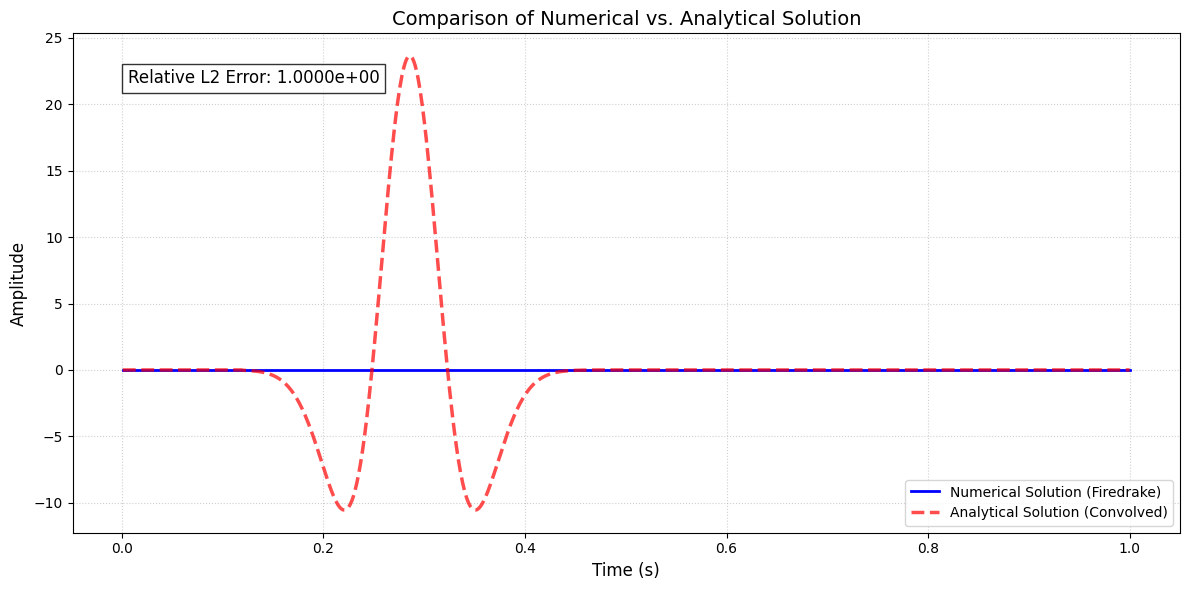

In [23]:
R_history = np.array([RickerWavelet(t_val, freq, amp) for t_val in time_points])
u_analytical_convolved = perform_convolution(G_history, R_history, dt)
L2_error = calculate_L2_error(u_numerical_history, u_analytical_convolved)
plot_comparison(time_points, u_numerical_history, u_analytical_convolved, receptor_coords, L2_error)